# Flatiron School Phase 4 Project

Student name: **Angelo Turri**

Student pace: **self paced**

Project finish date: ****

Instructor name: **Mark Barbour**

Blog post URL: **[x]**

# INTRODUCTION

### Stakeholder



### Data: Origin & Usage



### Methods Justification & Value to Stakeholder



### Limitations



### Model Evaluation



In [120]:
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
from statsmodels.tsa.stattools import adfuller, kpss
from sklearn.metrics import mean_squared_error, mean_absolute_error
from IPython.display import clear_output, display_html
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf
from statsmodels.tsa.stattools import pacf, acf
from statsmodels.tsa.arima.model import ARIMA
import time
from statsmodels.tsa.statespace.sarimax import SARIMAX

import warnings
warnings.filterwarnings("ignore")

In [2]:
data = pd.read_csv('data/zillow_data.csv')

In [3]:
def melt_data(df):
    """
    Takes the zillow_data dataset in wide form or a subset of the zillow_dataset.  
    Returns a long-form datetime dataframe 
    with the datetime column names as the index and the values as the 'values' column.
    
    If more than one row is passes in the wide-form dataset, the values column
    will be the mean of the values from the datetime columns in all of the rows.
    """
    
    melted = pd.melt(df, id_vars=['RegionName', 'RegionID', 'SizeRank', 'City', 'State', 'Metro', 'CountyName'], var_name='time')
    melted['time'] = pd.to_datetime(melted['time'], infer_datetime_format=True)
    melted = melted.dropna(subset=['value'])
    melted.set_index('time', inplace=True)
    return melted

In [7]:
# Changing from wide to long format
df = melt_data(data)

# Making sure each zipcode in the dataset has the full 265 months of data
df['zipcount'] = df['RegionName'].map(df.RegionName.value_counts())
df = df[df.zipcount==265]

# Changing the name of the zipcode column to accurately reflect what it contains.
df['zipcode'] = df['RegionName']
df.drop(['RegionName'], axis=1, inplace=True)

In [5]:
ad_2012 = df[df.index>'2011-12-1'].copy()
grouped = ad_2012.groupby('time').aggregate({'value':'mean'})

# General trend of house price data

You can see the effects of the 2008 housing market crash on what was an otherwise ever-increasing series of data points. This crash was an anomaly in the general upward trend of housing prices. I will only keep data after 2012, which is when the housing market slump seemed to be over.

In [9]:
grouped = df.groupby('time').aggregate({'value':'mean'})

<Axes: xlabel='time'>

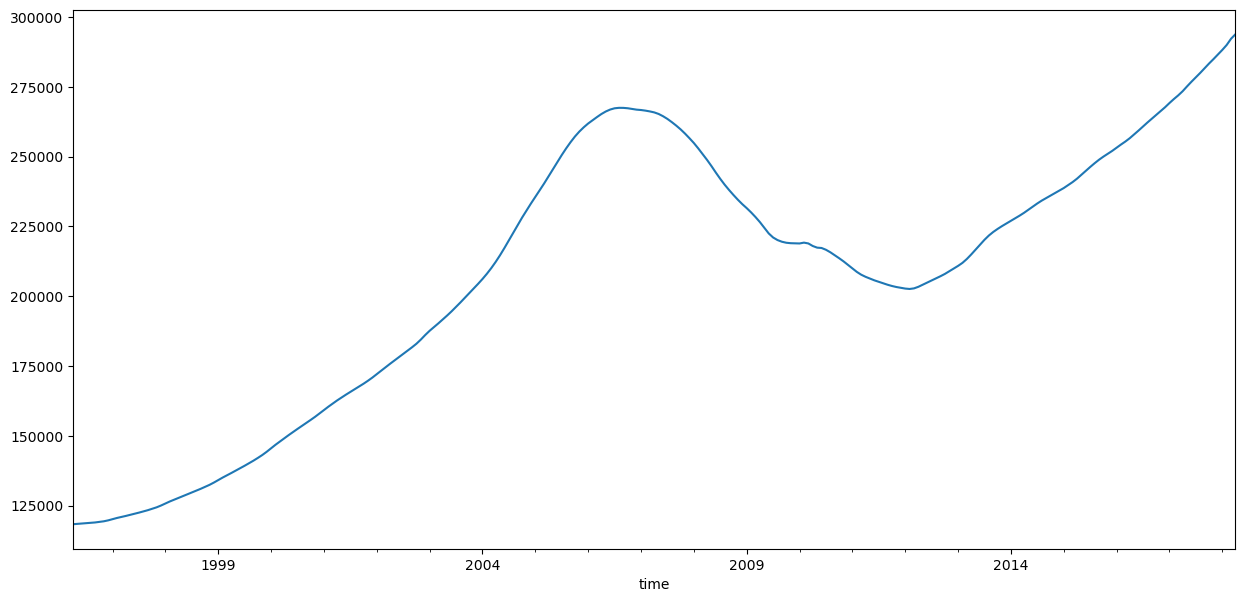

In [12]:
fig, ax = plt.subplots(figsize=(15,7))
grouped.value.plot()

# Data after the housing market crash

As expected, we have removed the anomalous housing market crash and what remains is a normal, linearly trending group of data for housing prices. This is the data that we will use for our models.

In [14]:
# Keeping data during and after 2012
ad_2012 = df[df.index>'2011-12-1'].copy()
grouped = ad_2012.groupby('time').aggregate({'value':'mean'})

<Axes: xlabel='time'>

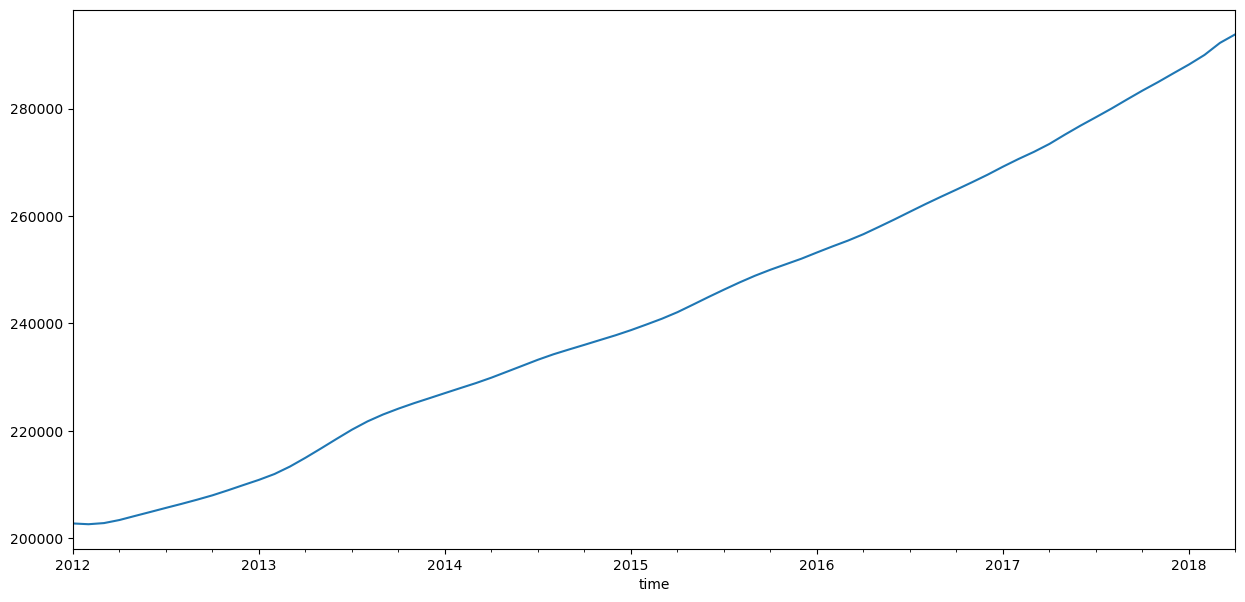

In [16]:
fig, ax = plt.subplots(figsize=(15,7))
grouped.value.plot()

# Number of zipcodes

Our stakeholder wants us to examine all the zipcodes in the dataset. There are 13,684 zipcodes in total, spread out across all 50 states. To find out which zipcodes are the best ones to invest in, we will have to forecast housing prices in each zipcode, which means fitting at least one model to each. ARIMA and SARMIAX do not take categorical exogenous variables, only numerical ones, which excludes the zipcode variable from being included in either type of model.

In [54]:
df.dtypes

RegionID        int64
SizeRank        int64
City           object
State          object
Metro          object
CountyName     object
value         float64
zipcount        int64
zipcode         int64
dtype: object

In [17]:
df.zipcode.nunique()

13684

In [55]:
df.State.nunique()

50

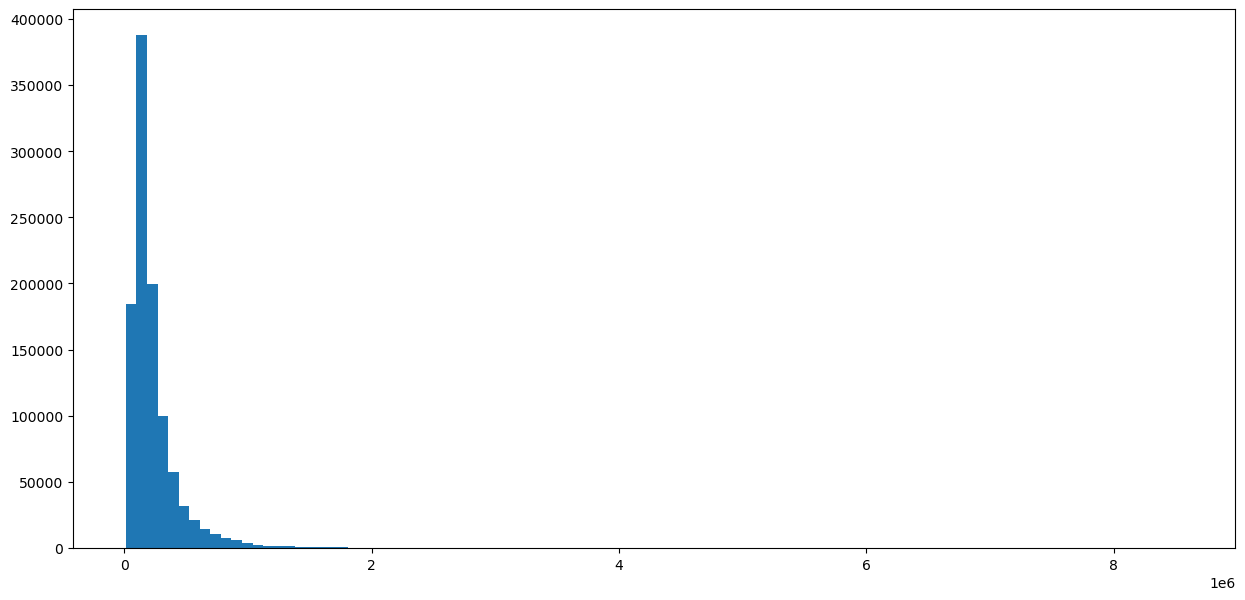

In [62]:
fig, ax = plt.subplots(figsize=(15,7))
ax.hist(ad_2012.value, bins=100);

# Kinds of zipcodes

Although the aggregated dataset shows a clear upwards trend, not all zipcodes follow this pattern. There are zipcodes that follow a very linear upward trajectory, but there are others that follow a more cyclical path. This suggests that there is no one model that will fit well to all the zipcodes.

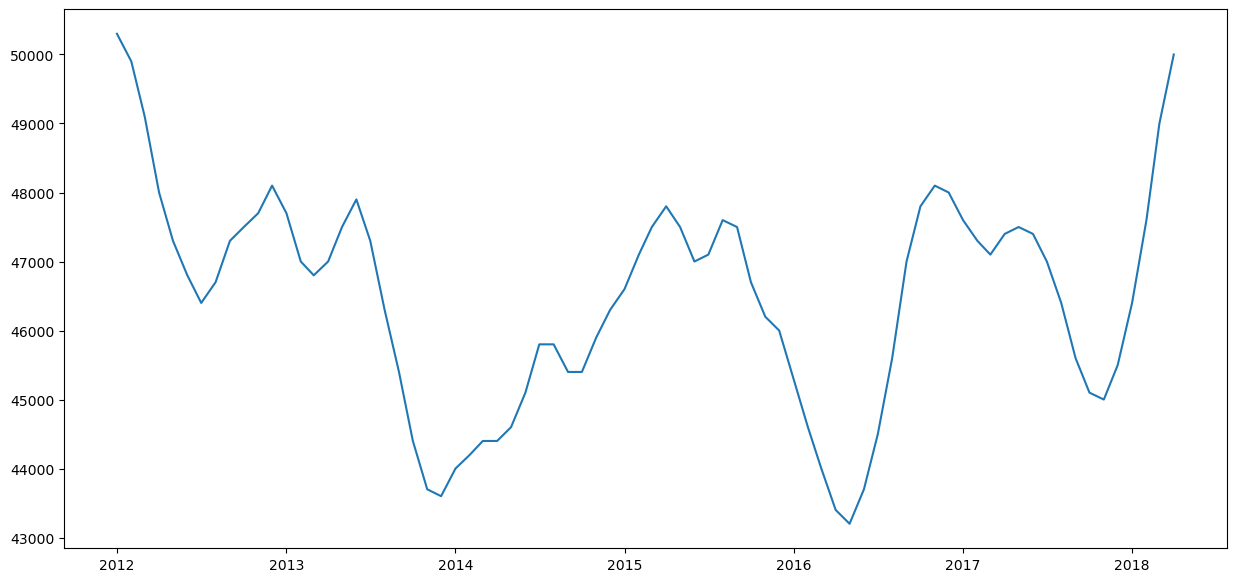

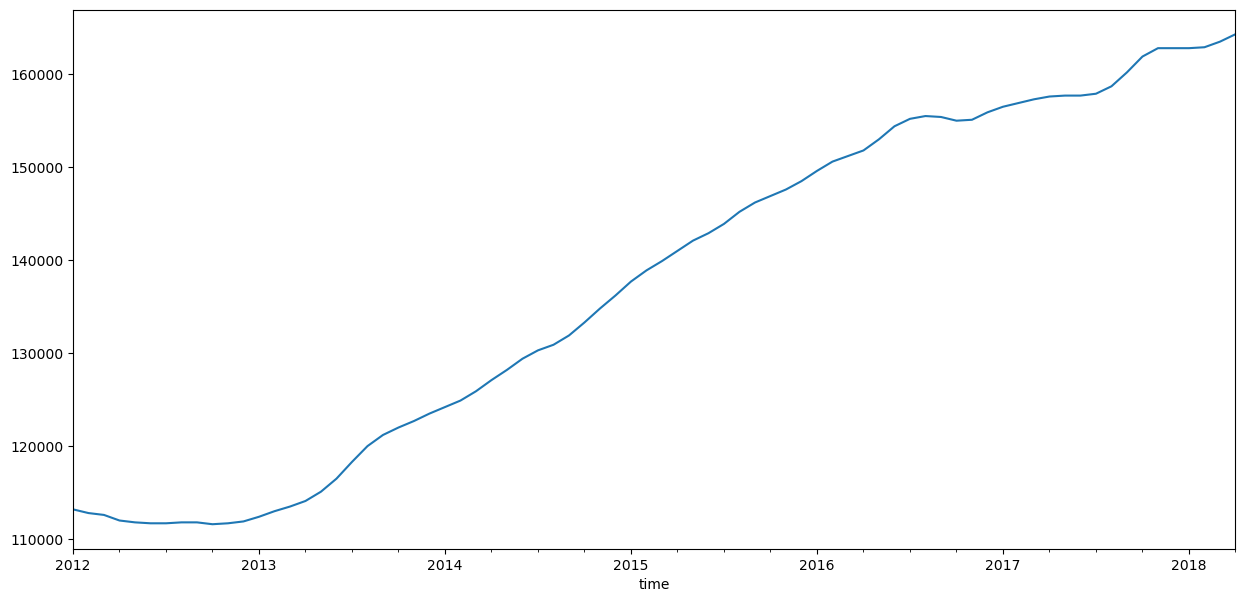

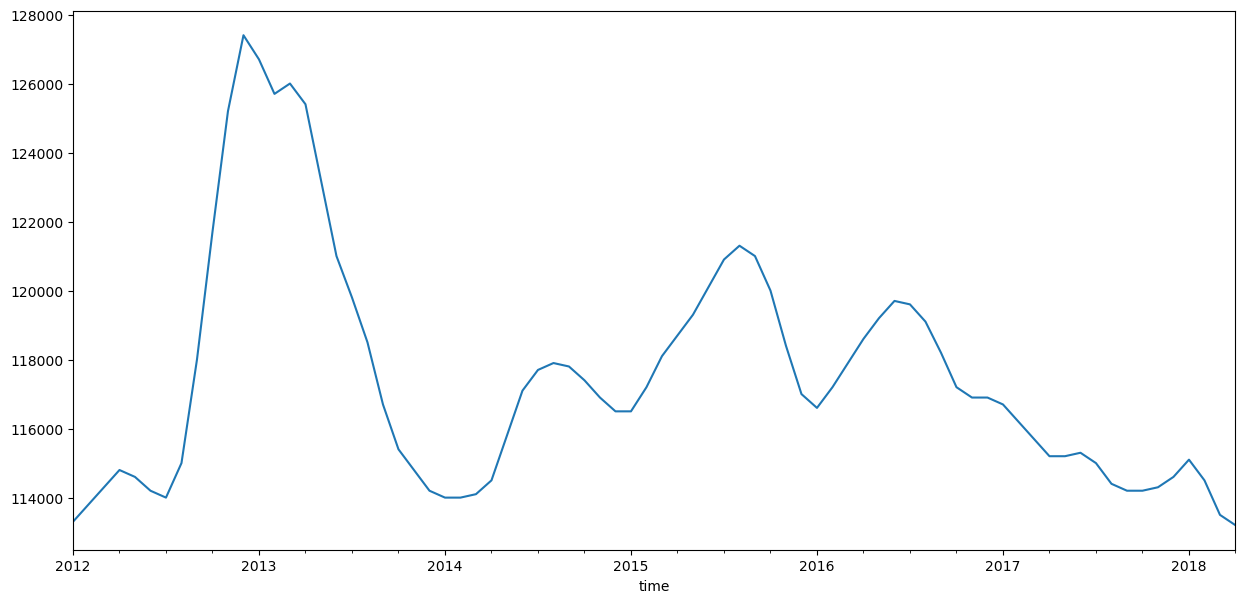

In [63]:
fig, ax = plt.subplots(figsize=(15,7))
ax.plot(ad_2012[ad_2012.zipcode==18702].value)

fig, ax = plt.subplots(figsize=(15,7))
ad_2012[ad_2012.zipcode==77084].value.plot()

fig, ax = plt.subplots(figsize=(15,7))
ad_2012[ad_2012.zipcode==61611].value.plot();

# Naive Models

The baseline naive model we will use is a model with all values shifted forward by 1.

A successful model will successfully extract all temporal components from each zipcode's time series, and the accompanying model residuals will be stationary.

Only 46% of the models actually reduced their accompanying time series to a white noise model. The average mse of our models was 12.7 million. This will be our benchmark for other models.

In [109]:
st = time.time()

mses = []
ad_pvalues, kpss_pvalues = [], []
residuals_list = []

for i in range(len(ad_2012.zipcode.unique())):
    
    zc = ad_2012.zipcode.unique()[i]
    zipcode = ad_2012[ad_2012.zipcode==zc].value
    shifted = zipcode.shift(1)[1:]
    
    mse = mean_squared_error(zipcode[1:], shifted)
    mses.append(mse)
    
    residuals = shifted-zipcode[1:]
    residuals_list.append(residuals)
    
    dftest = adfuller(residuals)
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
    ad_pvalues.append(dfoutput['p-value'])
    
    kpsstest = kpss(residuals, regression='ct')
    kpss_pvalues.append(kpsstest[1])
    
    clear_output(wait=True)
    print(f"Zipcode #{i+1}/{ad_2012.zipcode.nunique()} done.")
    
elapsed_time = time.time() - st
print("Execution time: " + str(elapsed_time) + " seconds")

Zipcode #13684/13684 done.
Execution time: 154.43095207214355 seconds


In [110]:
naive_model_df = pd.DataFrame({'zipcode': ad_2012.zipcode.unique(), 
                               'mse': mses, 
                               'adfuller_pvalue': ad_pvalues, 
                               'kpss_pvalue': kpss_pvalues, 
                               'residuals': residuals_list})

In [111]:
len(naive_model_df.query("adfuller_pvalue<0.05 & kpss_pvalue>0.05"))/len(naive_model_df)

0.4621455714703303

In [246]:
naive_model_df.mse.mean()

12720745.961219914

In [314]:
len(naive_model_df.query("mse>1000000000"))

16

In [315]:
naive_model_df.query("mse<1000000000").mse.mean()

9623190.8496732

<Axes: >

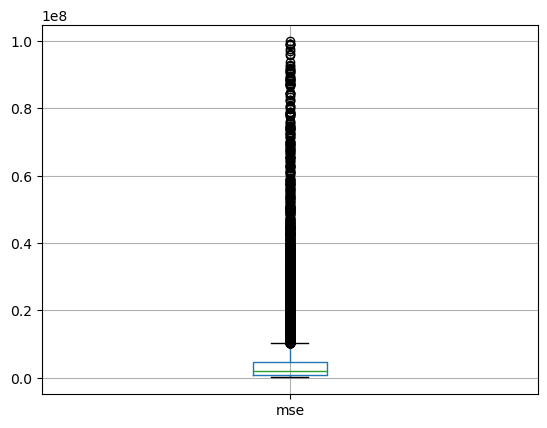

In [287]:
naive_model_df.query("mse<100000000").boxplot(column=['mse'])

# Deciding our parameters for the ARIMA model

Looking at our autocorrelation and partial autocorrelation plots, it looks like we should at least make one difference on the data. Let's perform the difference and then re-evaluate the partial and autocorrelation plots.

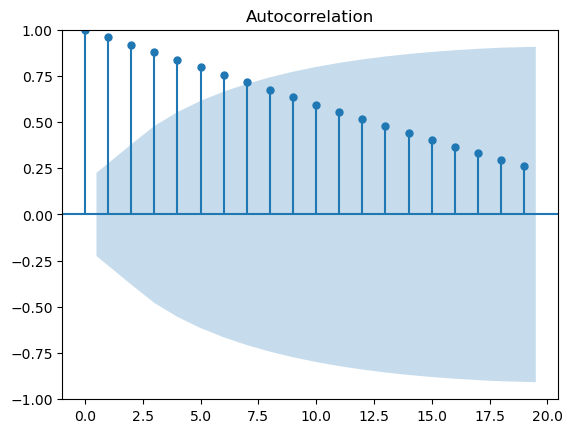

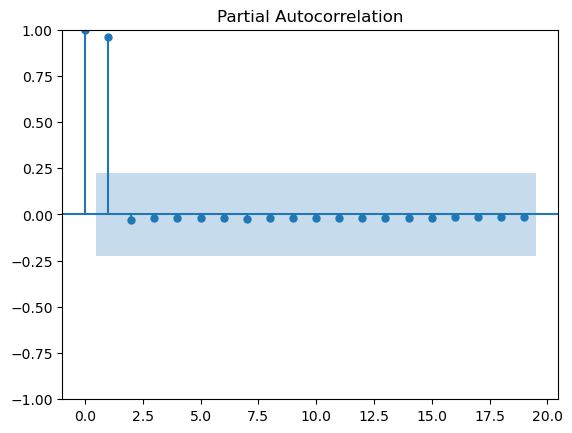

In [154]:
plot_acf(grouped.value);
plot_pacf(grouped.value);

# Differencing the series

After differencing the aggregated series, the number of significant lags went down from 7 to 3, two of which are well outside the significance boundary. Our partial autocorrelation plot remains the same.

These suggest that our first model should have at least two AR terms, one MA term, and one difference.

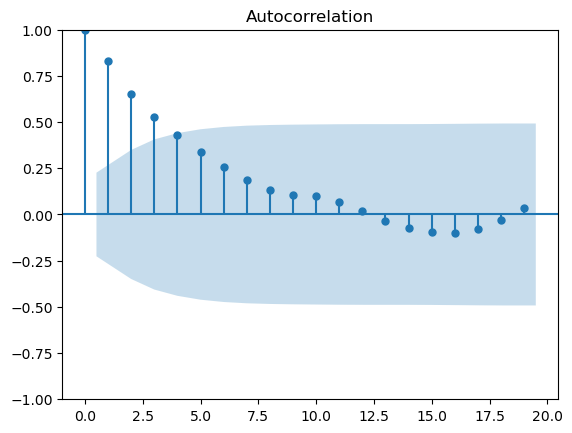

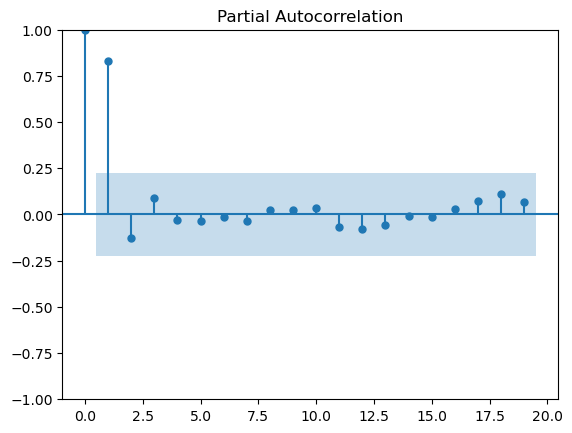

In [193]:
plot_acf(grouped.diff(1).value[1:]);
plot_pacf(grouped.diff(1).value[1:]);

In [215]:
st = time.time()

mses = []
ad_pvalues, kpss_pvalues = [], []
residuals_list = []
model_type = []
predictions_list = []

for i in range(len(ad_2012.zipcode.unique())):
    
    zc = ad_2012.zipcode.unique()[i]
    zipcode = ad_2012[ad_2012.zipcode==zc].value
    print(f"Zipcode: {zc}")
    
    try:
        model = ARIMA(zipcode, order=(2, 1, 1)).fit()
        model_type.append('2 MA terms')
    except:
        model = ARIMA(zipcode, order=(1, 1, 1)).fit()
        model_type.append('1 MA term')
            
    predictions = model.predict()
    predictions_list.append(predictions)
    
    mse = mean_squared_error(zipcode[1:], predictions[1:])
    mses.append(mse)
    
    residuals = predictions[1:]-zipcode[1:]
    residuals_list.append(residuals)
    
    dftest = adfuller(residuals)
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
    ad_pvalues.append(dfoutput['p-value'])
    
    kpsstest = kpss(residuals, regression='ct')
    kpss_pvalues.append(kpsstest[1])
    
    clear_output(wait=True)
    print(f"Zipcode #{i+1}/{ad_2012.zipcode.nunique()} done.")
    
elapsed_time = time.time() - st
print("Execution time: " + str(elapsed_time) + " seconds")

Zipcode #13684/13684 done.
Execution time: 787.3563270568848 seconds


In [217]:
arima_model_df = pd.DataFrame({'zipcode': ad_2012.zipcode.unique(), 
                               'model_type': model_type,
                               'mse': mses, 
                               'adfuller_pvalue': ad_pvalues, 
                               'kpss_pvalue': kpss_pvalues, 
                               'residuals': residuals_list, 
                               'predictions': predictions_list})

In [218]:
arima_model_df

,zipcode,model_type,mse,adfuller_pvalue,kpss_pvalue,residuals,predictions
0,60657,2 MA terms,3.039687e+07,0.147609,0.076034,2012-01-01 -737700.000000 2012-02-01 31...,2012-01-01 0.000000e+00 2012-02-01 7.368...
1,75070,2 MA terms,7.647484e+05,0.056723,0.100000,2012-01-01 -199600.000000 2012-02-01 12...,2012-01-01 0.000000 2012-02-01 2013...
2,77494,2 MA terms,1.711159e+06,0.020455,0.100000,2012-01-01 -248600.000000 2012-02-01 7...,2012-01-01 0.000000 2012-02-01 2523...
3,60614,2 MA terms,5.166262e+07,0.117860,0.075952,2012-01-01 -928900.000000 2012-02-01 45...,2012-01-01 0.000000e+00 2012-02-01 9.284...
4,79936,2 MA terms,1.115470e+05,0.123631,0.072471,2012-01-01 -112400.000000 2012-02-01 5...,2012-01-01 0.000000 2012-02-01 1127...
...,...,...,...,...,...,...,...
13679,1338,2 MA terms,2.658583e+06,0.000014,0.088866,2012-01-01 -174600.000000 2012-02-01 18...,2012-01-01 0.000000 2012-02-01 1765...
13680,3293,2 MA terms,3.391692e+06,0.592588,0.084774,2012-01-01 -185300.000000 2012-02-01 18...,2012-01-01 0.000000 2012-02-01 1884...
13681,40404,2 MA terms,7.359776e+05,0.029256,0.093476,2012-01-01 -107100.000000 2012-02-01 10...,2012-01-01 0.000000 2012-02-01 1087...
13682,81225,2 MA terms,7.170632e+07,0.078537,0.069197,2012-01-01 -513300.000000 2012-02-01 63...,2012-01-01 0.000000 2012-02-01 5180...


In [319]:
len(arima_model_df.query("adfuller_pvalue<0.05 & kpss_pvalue>0.05"))/len(naive_model_df)

0.4994153756211634

In [220]:
arima_model_df.mse.mean()

65435670674.40107

In [316]:
len(arima_model_df.query("mse>1000000000"))

52

In [318]:
arima_model_df.query("mse<1000000000").mse.mean()

5819107.9291226305